In [1]:
import nbimporter
from extract_digits import (load_image, threshold_img, find_center_3by3_square, 
                            find_all_squares, extract_digit_images, plot_all_squares,
                            plot_center_3by3, to_rgb, find_square_by_fill)
from solve_sodoku import SodokuField
from recognize_digits import DigitPredictor
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt

Importing Jupyter notebook from extract_digits.ipynb
Importing Jupyter notebook from solve_sodoku.ipynb
Importing Jupyter notebook from recognize_digits.ipynb


Using TensorFlow backend.


In [2]:
def try_except(try_fn, except_fn=None):
    try:
        return True, try_fn()
    except:
        return False, (except_fn() if except_fn else None)


def copy_image(src, dest, dest_topleft):
    dest_channels = dest.shape[2]
    
    if len(src.shape) == 2:
        src_rows, src_cols = src.shape
        new_src = np.zeros((src_rows, src_cols, dest_channels))
        for i in range(dest_channels):
            new_src[:, :, i] = src
        src = new_src
    else:
        src_rows, src_cols, src_channels = src.shape
        assert src_channels == dest_channels

    dest_top, dest_left = dest_topleft
    dest[dest_top:dest_top+src_rows, dest_left:dest_left+src_cols, :] = src
    return dest

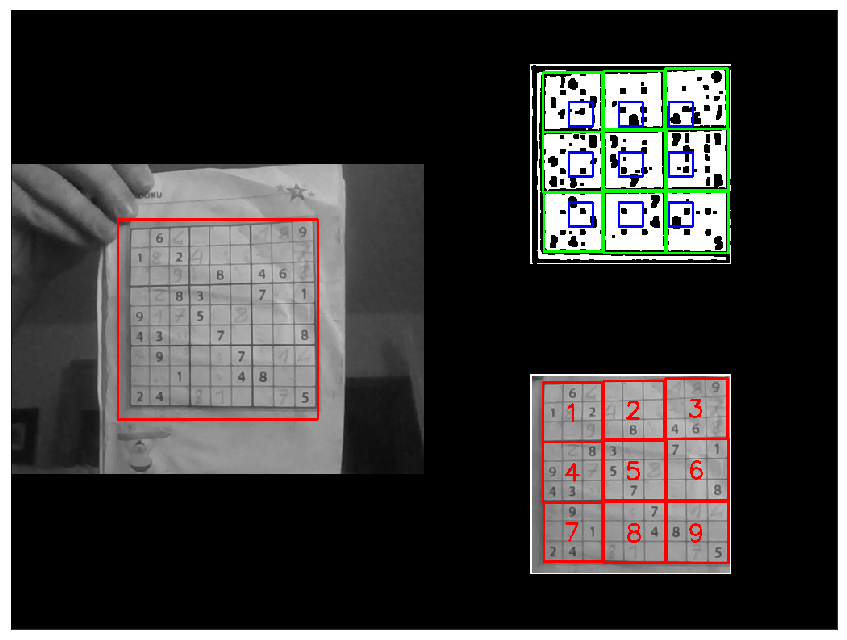

In [4]:
cap = cv2.VideoCapture(0)

try:
    success = False
    while True:
        # capture frame and apply initial pre-processing
        ret, frame = cap.read()
        res = load_image(frame)
        orig = to_rgb(res['img'].copy())
        rows, cols, _ = orig.shape
        
        # draw target and crop
        half_target_size = int(min(rows, cols) * 0.325)
        target_top = int(rows / 2 - half_target_size)
        target_bot = int(rows / 2 + half_target_size)
        target_left = int(cols / 2 - half_target_size)
        target_right = int(cols / 2 + half_target_size)
        
        cv2.rectangle(orig, (target_left, target_top), (target_right, target_bot), (255, 0, 0), 2)
        res['img'] = orig[target_top:target_bot, target_left:target_right, 0]
        
        final = np.zeros((rows * 2, cols * 2, 3))
        copy_image(orig, final, (rows // 2, 0))
        
        # binarize
        res = threshold_img(res)
        bin_shown = to_rgb(res['bin'].copy())
        
        # recognize squares by focusing on a 9-points grid
        for i in range(3):
            for j in range(3):
                px = (i + 1) * half_target_size / 2
                py = (j + 1) * half_target_size / 2
                
                half_size = 15
                ax, ay, bx, by = find_square_by_fill(
                    res['bin'], 
                    px - half_size, py - half_size, 
                    px + half_size, py + half_size, 0.5
                )
                cv2.rectangle(
                    bin_shown, (int(py - half_size), int(px - half_size)),
                    (int(py + half_size), int(px + half_size)), (0, 0, 255), 2
                )
                cv2.rectangle(bin_shown, (ax, ay), (bx, by), (0, 255, 0), 2)
        copy_image(bin_shown, final, (target_top, target_left + cols))
        
        # find squares by identifying the center square first
        ok, res = try_except(lambda: find_center_3by3_square(res))
        
        if ok:
            ok, res = try_except(lambda: find_all_squares(res))
        
        if ok:
            copy_image(plot_all_squares(res, None), final, (target_top + rows, target_left + cols))
            ok, res = try_except(lambda: extract_digit_images(res))
        
        # Display the resulting frame (horizontal mirror to make interaction easier)
        cv2.imshow('frame', final.astype(np.uint8)[:, ::-1, :])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        # check if squares are reasonable
        if ok and 'squares' in res:
            success = True  # let's be optimists
            
            # exactly 9 squares
            if len(res['squares']) != 9:
                success = False
            
            # longest side must be less than 1/3 of picture
            max_side = max(max((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if max_side > 2 * half_target_size / 3:
                success = False
            
            # shortest side must be more than 1/5 of the picture
            min_side = min(min((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if min_side < 2 * half_target_size / 4:
                success = False
            
            # smallest area / largest area > 0.92
            areas = [(bx - ax) * (by - ay) for ax, ay, bx, by in res['squares']]
            if min(areas) / max(areas) < 0.9:
                success = False
            
            if success:
                break
    
    plt.figure(figsize=(12, 9))
    plt.imshow(final.astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
finally:
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

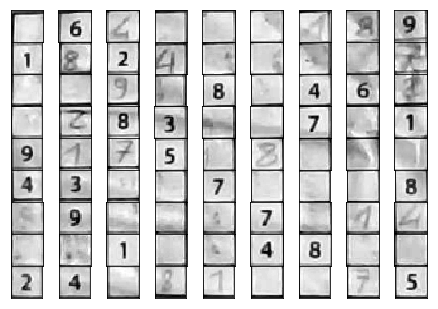

In [5]:
res = extract_digit_images(res)

for i, digit in enumerate(res['digits']):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digit['img'], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

In [6]:
preds = DigitPredictor().predict_digits([digit['img'] for digit in res['digits']], return_proba=True)
confidence = preds.max(axis=1)

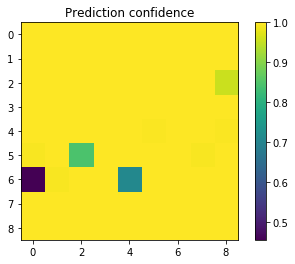

In [7]:
plt.imshow(confidence.reshape((9, 9)))
plt.colorbar()
plt.title('Prediction confidence')
plt.show()

---
I am not sure of the content of the cell in row 6 and column 3
I think it is either a blank (84.5%) or a 1 (15.2%)


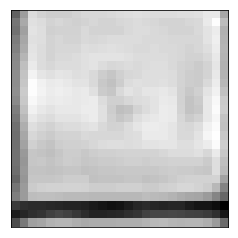

What is the correct label (enter to accept my guess: blank)?  


Accepted as blank
---
I am not sure of the content of the cell in row 7 and column 1
I think it is either a 8 (45.6%) or a 5 (42.5%)


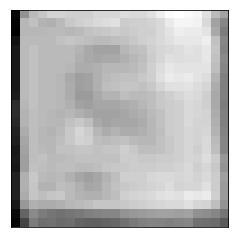

What is the correct label (enter to accept my guess: 8)?  


Accepted as 8
---
I am not sure of the content of the cell in row 7 and column 5
I think it is either a blank (71.0%) or a 1 (22.6%)


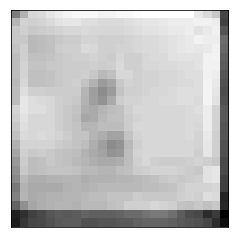

What is the correct label (enter to accept my guess: blank)?  


Accepted as blank


In [11]:
correct_labels = []
for i, (probas, digit_data) in enumerate(zip(preds, res['digits'])):
    conf, guessed_label = probas.max(), probas.argmax()
    if conf > 0.85:
        correct_labels.append(guessed_label)
    else:
        by_confidence = sorted([
             (str(lbl) if lbl else 'blank', 100 * conf)
            for lbl, conf in enumerate(probas)
        ], key=lambda x: -x[1])
        
        row, col = i // 9 + 1, i % 9 + 1
        print('---')
        print('I am not sure of the content of the cell in row %d and column %d' % (row, col))
        print('I think it is either', ' or '.join(['a %s (%.1f%%)' % lbl for lbl in by_confidence[:2]]))
        plt.imshow(digit_data['img'], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        label = input('What is the correct label (enter to accept my guess: %s)? ' % by_confidence[0][0])
        if label and label.isdigit():
            correct_labels.append(int(label))
            print('Corrected to', label)
        elif label:
            correct_labels.append(None)
            print('Corrected to blank')
        else:
            correct_labels.append(guessed_label)
            print('Accepted as', guessed_label or 'blank')

In [12]:
def get_input(prompt, accept_regex, lowercase=True):
    while True:
        ans = input(prompt)
        if lowercase:
            ans = ans.lower()
            
        match = re.match(accept_regex, ans)
        if not match:
            print('Invalid answer.')
        else:
            return match

while True:
    SodokuField(correct_labels).pretty_print()
    correct = get_input('Is this correct? (y/n)', r'(y|n|yes|no)').group()
    if correct in {'y', 'yes'}:
        break
    
    row = int(get_input('Which row is the mistake in? (1-9) ', r'[1-9]').group())
    col = int(get_input('Which column is the mistake in? (1-9) ', r'[1-9]').group())

    idx = 9 * (row - 1) + col - 1
    guess = correct_labels[idx]
    label = input('I thought it was a %s. What is it actually? ' % (guess or 'blank'))
    correct_labels[idx] = int(label) if label.isdigit() else None
    print('Corrected to', correct_labels[idx] or 'blank')

+---------+---------+---------+
|    6  4 |         | 1  8  9 |
| 1  8  2 | 4       |       7 |
|       9 |    8    | 4  6  8 |
+---------+---------+---------+
|    2  8 | 3       | 7     1 |
| 9  1  7 | 5     8 |         |
| 4  3    |    7    |       8 |
+---------+---------+---------+
| 8  9    |       7 |    1  4 |
|       1 |       4 | 8       |
| 2  4    | 8  1    |    7  5 |
+---------+---------+---------+



Is this correct? (y/n) n
Which row is the mistake in? (1-9)  3
Which column is the mistake in? (1-9)  9
I thought it was a 8. What is it actually?  2


Corrected to 2
+---------+---------+---------+
|    6  4 |         | 1  8  9 |
| 1  8  2 | 4       |       7 |
|       9 |    8    | 4  6  2 |
+---------+---------+---------+
|    2  8 | 3       | 7     1 |
| 9  1  7 | 5     8 |         |
| 4  3    |    7    |       8 |
+---------+---------+---------+
| 8  9    |       7 |    1  4 |
|       1 |       4 | 8       |
| 2  4    | 8  1    |    7  5 |
+---------+---------+---------+



Is this correct? (y/n) y


In [13]:
sodoku = SodokuField(correct_labels)
solved, _ = sodoku.brute_force()
sodoku.pretty_print()
solved

+---------+---------+---------+
| 5  6  4 | 7  3  2 | 1  8  9 |
| 1  8  2 | 4  9  6 | 5  3  7 |
| 3  7  9 | 1  8  5 | 4  6  2 |
+---------+---------+---------+
| 6  2  8 | 3  4  9 | 7  5  1 |
| 9  1  7 | 5  2  8 | 3  4  6 |
| 4  3  5 | 6  7  1 | 2  9  8 |
+---------+---------+---------+
| 8  9  3 | 2  5  7 | 6  1  4 |
| 7  5  1 | 9  6  4 | 8  2  3 |
| 2  4  6 | 8  1  3 | 9  7  5 |
+---------+---------+---------+



True